# import modules

In [1]:
import keras
from keras.utils import plot_model,to_categorical
from keras.layers import Dense,LSTM,Bidirectional,TimeDistributed,Conv1D,MaxPool1D,Concatenate,Dropout,BatchNormalization,Add
from keras import Model,Input
from keras.layers import Reshape,Flatten
import numpy as np
from sklearn.model_selection import train_test_split
import keras.backend as K
import keras.callbacks as kcallbacks
from sklearn.preprocessing import LabelEncoder
import string
from keras.optimizers import SGD
import warnings
# from lsuv_init import LSUVinit
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Load Features

In [2]:
alphabet_set=list(string.ascii_letters[:26])
alphabet_set.insert(0,'0')

## One-hot Encoding

# Models


In [4]:
X_gabor_train = np.load('./feature/X_gabor_train.npy')
X_gabor_val = np.load('./feature/X_gabor_validation.npy')

In [11]:
y_tone_train =np.load('./feature/y_tone_train.npy')
y_tone_val =np.load('./feature/y_tone_validation.npy')

le=LabelEncoder()
y_tone_train=le.fit_transform(y_tone_train)
y_tone_val=le.fit_transform(y_tone_val)

CLASSES_LIST=le.classes_
print(CLASSES_LIST)

y_tone_train=to_categorical(y_tone_train,num_classes=4)
y_tone_val=to_categorical(y_tone_val,num_classes=4)


[1 2 3 4]


In [17]:
print(y_tone_val.shape)
y_tone_train = y_tone_train.reshape(4233,1,4)
y_tone_val = y_tone_val.reshape(471,1,4)


(471, 4)


In [18]:
X_mfcc_train=np.load('./feature/mfcc_fusion_train.npy')
X_mfcc_val=np.load('./feature/mfcc_fusion_validation.npy')

In [3]:
NUM_CLASSES=4
BATCH_SIZE=128
EPOCHS=100
MODEL_SAVE_PATH='./models/early_merged_tone_cnn.h5'

K.clear_session()
inputs1=Input(shape=(35,7),name='inputs_gabor')


x_1=Conv1D(filters=64,kernel_size=3,padding='same')(inputs1)
x_1=MaxPool1D()(x_1)
x_2=Conv1D(filters=128,kernel_size=8,padding='same')(inputs1)
x_2=MaxPool1D()(x_2)
x_3=Conv1D(filters=256,kernel_size=13,padding='same')(inputs1)
x_3=MaxPool1D()(x_3)
#x_4=Conv1D(filters=256,kernel_size=18,padding='same')(inputs)
#x_4=MaxPool1D()(x_4)
#x_5=Conv1D(filters=256,kernel_size=25,padding='same')(inputs)
#x_5=MaxPool1D()(x_5)
#short_cut=Conv1D(filters=448,kernel_size=19,padding='valid')(inputs)
x=Concatenate()([x_1,x_2,x_3])

#x=Add()([x,short_cut])
x=BatchNormalization()(x)
x=Conv1D(filters=64,kernel_size=16)(x)

out_gabor = MaxPool1D()(x)



#x=Dropout(0.25)(x)
#x=TimeDistributed(Dense(NUM_CLASSES,activation='softmax'))(x)

inputs2=Input(shape=(50,57),name='inputs_mfcc')
x=Bidirectional(LSTM(64,return_sequences=True,dropout=0.25))(inputs2)
x=Bidirectional(LSTM(100,dropout=0.25))(x)
out_mfcc= Reshape((1,200))(x)


merged_layer= Concatenate()([out_gabor,out_mfcc])
merged_layer = BatchNormalization()(merged_layer)
merged_layer = TimeDistributed(Dense(64))(merged_layer)
merged_layer = Dropout(0.25)(merged_layer)
merged_layer = TimeDistributed(Dense(NUM_CLASSES,activation='softmax'))(merged_layer)
merged_model = Model([inputs1,inputs2],merged_layer)
merged_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_gabor (InputLayer)       (None, 35, 7)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 35, 64)       1408        inputs_gabor[0][0]               
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 35, 128)      7296        inputs_gabor[0][0]               
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 35, 256)      23552       inputs_gabor[0][0]               
__________________________________________________________________________________________________
max_poolin

In [36]:

merged_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#plot_model(merged_model,'merged_model_initial.jpg',show_shapes=True)
lr_reduce=kcallbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=6,verbose=1,min_lr=0.00001)
save_model=kcallbacks.ModelCheckpoint(filepath=MODEL_SAVE_PATH,monitor='val_acc',verbose=1,save_best_only=True)
callback_list=[save_model,lr_reduce]
history=merged_model.fit(x=[X_gabor_train,X_mfcc_train],y=y_tone_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=([X_gabor_val,X_mfcc_val],y_tone_val),
                  callbacks=callback_list)

Train on 4233 samples, validate on 471 samples
Epoch 1/100
4233/4233 [==============================] - 16s 4ms/step - loss: 1.5739 - acc: 0.4066 - val_loss: 1.3389 - val_acc: 0.4926

Epoch 00001: val_acc improved from -inf to 0.49257, saving model to ./models/early_merged_tone_cnn.h5
Epoch 2/100
4233/4233 [==============================] - 9s 2ms/step - loss: 1.1531 - acc: 0.5379 - val_loss: 1.0587 - val_acc: 0.5754

Epoch 00002: val_acc improved from 0.49257 to 0.57537, saving model to ./models/early_merged_tone_cnn.h5
Epoch 3/100
4233/4233 [==============================] - 9s 2ms/step - loss: 1.0376 - acc: 0.5816 - val_loss: 0.8425 - val_acc: 0.6497

Epoch 00003: val_acc improved from 0.57537 to 0.64968, saving model to ./models/early_merged_tone_cnn.h5
Epoch 4/100
4233/4233 [==============================] - 9s 2ms/step - loss: 0.9325 - acc: 0.6244 - val_loss: 0.8228 - val_acc: 0.6879

Epoch 00004: val_acc improved from 0.64968 to 0.68790, saving model to ./models/early_merged_ton


Epoch 00038: val_acc did not improve from 0.95329
Epoch 39/100
4233/4233 [==============================] - 9s 2ms/step - loss: 0.0824 - acc: 0.9721 - val_loss: 0.1628 - val_acc: 0.9448

Epoch 00039: val_acc did not improve from 0.95329
Epoch 40/100
4233/4233 [==============================] - 9s 2ms/step - loss: 0.0715 - acc: 0.9757 - val_loss: 0.1777 - val_acc: 0.9490

Epoch 00040: val_acc did not improve from 0.95329
Epoch 41/100
4233/4233 [==============================] - 9s 2ms/step - loss: 0.0645 - acc: 0.9759 - val_loss: 0.1772 - val_acc: 0.9554

Epoch 00041: val_acc improved from 0.95329 to 0.95541, saving model to ./models/early_merged_tone_cnn.h5
Epoch 42/100
4233/4233 [==============================] - 9s 2ms/step - loss: 0.0682 - acc: 0.9766 - val_loss: 0.1785 - val_acc: 0.9554

Epoch 00042: val_acc did not improve from 0.95541
Epoch 43/100
4233/4233 [==============================] - 9s 2ms/step - loss: 0.0664 - acc: 0.9785 - val_loss: 0.1819 - val_acc: 0.9490

Epoch 000

## plot_curve

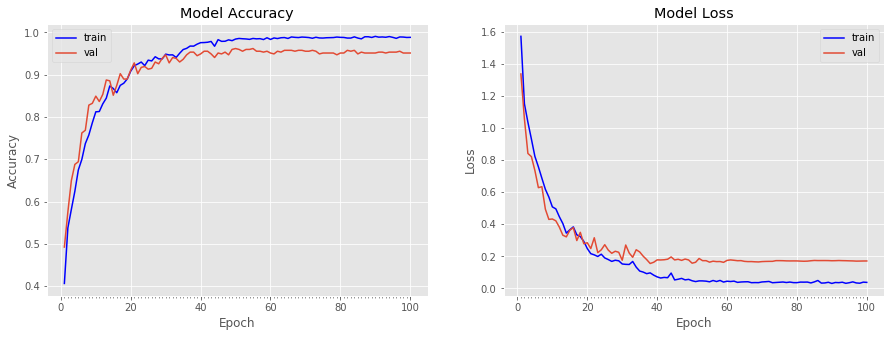

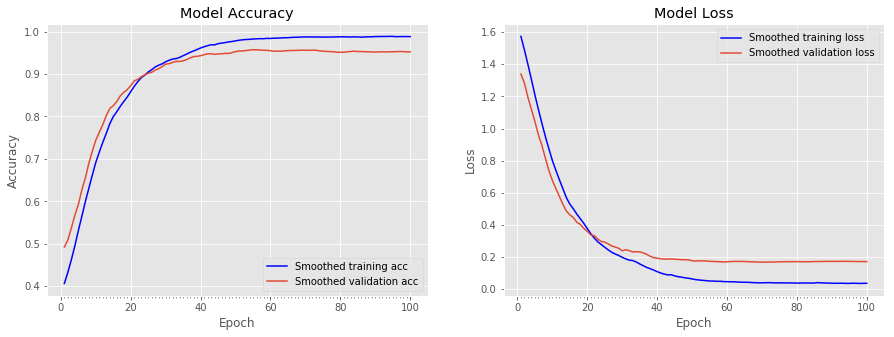

In [37]:
from help import plot_curve,plot_curve_with_smooth
%matplotlib inline 
plot_curve(history)
plot_curve_with_smooth(history)

## confusion_metrix

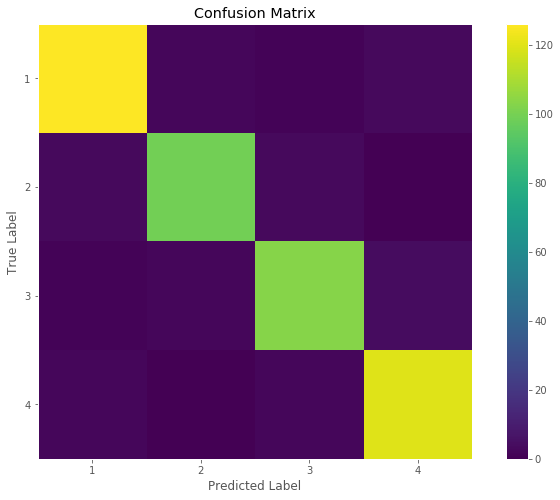

In [40]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
y_pred=merged_model.predict([X_gabor_val,X_mfcc_val])
y_pred=np.argmax(y_pred,axis=-1).ravel()
y_true=np.argmax(y_tone_val,axis=-1).ravel()
con_matrix=confusion_matrix(y_true=y_true,y_pred=y_pred)
#target_names=[alphabet_set[i] for i in range(4)]
def plot_confusion_matrix(confusion_mat):
    plt.figure(figsize=(12,8))
    plt.imshow(confusion_mat)
    plt.title('Confusion Matrix')
    plt.colorbar()
    labels = [1,2,3,4]
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.grid(False)
    plt.show() 
plot_confusion_matrix(con_matrix)

## classfication_report

In [44]:
from sklearn.metrics import classification_report

target_names = ['1', '2', '3','4']
print(classification_report(y_true,y_pred,digits=4,labels=[0,1,2,3],target_names=target_names))

              precision    recall  f1-score   support

           1     0.9545    0.9545    0.9545       132
           2     0.9612    0.9429    0.9519       105
           3     0.9450    0.9364    0.9406       110
           4     0.9449    0.9677    0.9562       124

   micro avg     0.9512    0.9512    0.9512       471
   macro avg     0.9514    0.9504    0.9508       471
weighted avg     0.9512    0.9512    0.9511       471



# predict test

In [14]:
merged_model.load_weights(MODEL_SAVE_PATH)


In [16]:
alphabet_set = {0:'1',1:'2',2:'3',3:'4'}

In [18]:
ID = 'person10_time1_group2_zhong_1'
temp = np.load('./gabor/'+ID+'.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test1 =[]
test1.append(temp[:35,])
test1 = np.array(test1)


test2 = np.load('./mfcc_data/'+ID+'.npy')
test2 = test2.reshape(1,50,57)


pred=merged_model.predict([test1,test2])

pred=np.argmax(pred,axis=-1)[0]

text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

(1, 35, 7)
Predict Label:1


In [19]:
ID = 'person6_time1_group1_ge_4'
temp = np.load('./gabor/'+ID+'.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test1 =[]
test1.append(temp[:35,])
test1 = np.array(test1)

test2 = np.load('./mfcc_data/'+ID+'.npy')
test2 = test2.reshape(1,50,57)


pred=merged_model.predict([test1,test2])

pred=np.argmax(pred,axis=-1)[0]

text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

(1, 35, 7)
Predict Label:4
